In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(folder, target_size=(256, 256)):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            resized_img = cv2.resize(img, target_size)
            images.append(resized_img)
            filenames.append(filename)
    return images, filenames

# Load and preprocess images and labels
train_images, image_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/images/")
train_labels, label_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/labels/")

# Ensure that images and labels are matched correctly
assert image_filenames == label_filenames, "Mismatch between image and label files"

# Convert lists to numpy arrays for easier manipulation
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Normalize pixel values
train_images = train_images / 255.0
train_labels = np.where(train_labels > 0, 1, 0).astype(np.float32)  # Binarize labels and convert to float32

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Reshape for the neural network (e.g., adding channel dimension for grayscale images)
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
    smooth = 1.0
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.keras.backend.sum(y_true, [1, 2, 3]) + tf.keras.backend.sum(y_pred, [1, 2, 3]) - intersection
    return tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D(size=(2, 2))(c5)
    merge6 = concatenate([c4, u6], axis=3)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D(size=(2, 2))(c6)
    merge7 = concatenate([c3, u7], axis=3)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = UpSampling2D(size=(2, 2))(c7)
    merge8 = concatenate([c2, u8], axis=3)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = UpSampling2D(size=(2, 2))(c8)
    merge9 = concatenate([c1, u9], axis=3)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', dice_coefficient, iou, precision, recall, f1_score])
    
    return model

# Create the model
model = unet_model()
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=16, 
                    verbose=1,
                    callbacks=[early_stopping])

# Check if early stopping was triggered
if len(history.history['val_loss']) < 100:
    print("Early stopping was triggered. Training stopped early.")
else:
    print("Training completed without early stopping.")

# Save the model
model.save("unet_model.h5")
print("Model saved as unet_model.h5")

C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_7[0][0], 

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step - accuracy: 0.5138 - dice_coefficient: 0.4373 - f1_score: 0.2568 - iou: 0.2670 - loss: 0.6924 - precision: 0.4041 - recall: 0.4603 - val_accuracy: 0.8352 - val_dice_coefficient: 0.4862 - val_f1_score: 0.8416 - val_iou: 0.3188 - val_loss: 0.6807 - val_precision: 0.7481 - val_recall: 0.9620
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.7030 - dice_coefficient: 0.4286 - f1_score: 0.5259 - iou: 0.2618 - loss: 0.6714 - precision: 0.7224 - recall: 0.6108 - val_accuracy: 0.4552 - val_dice_coefficient: 0.5816 - val_f1_score: 0.6257 - val_iou: 0.4079 - val_loss: 0.6873 - val_precision: 0.4552 - val_recall: 1.0000
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.3670 - dice_coefficient: 0.4947 - f1_score: 0.5366 - iou: 0.3202 - loss: 0.7397 - precision: 0.3690 - recall: 1.0000 - val_accuracy: 0.5593 - val_dice_coefficient: 0.4447 - val_f1_score: 0.0797 - val_iou: 0.2838 - val_loss: 0.6942 - val_precision: 0.8076 - va

Early stopping was triggered. Training stopped early.
Model saved as unet_model.h5


In [2]:
# Print the final metrics
final_metrics = {
    "accuracy": history.history['accuracy'][-1],
    "val_accuracy": history.history['val_accuracy'][-1],
    "loss": history.history['loss'][-1],
    "val_loss": history.history['val_loss'][-1],
    "dice_coefficient": history.history['dice_coefficient'][-1],
    "val_dice_coefficient": history.history['val_dice_coefficient'][-1],
    "iou": history.history['iou'][-1],
    "val_iou": history.history['val_iou'][-1],
    "precision": history.history['precision'][-1],
    "val_precision": history.history['val_precision'][-1],
    "recall": history.history['recall'][-1],
    "val_recall": history.history['val_recall'][-1],
    "f1_score": history.history['f1_score'][-1],
    "val_f1_score": history.history['val_f1_score'][-1]
}

for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

accuracy: 0.9529647827148438
val_accuracy: 0.9462982416152954
loss: 0.124053955078125
val_loss: 0.13415297865867615
dice_coefficient: 0.9097784161567688
val_dice_coefficient: 0.9172769784927368
iou: 0.8216163516044617
val_iou: 0.8490705490112305
precision: 0.9343110918998718
val_precision: 0.9677296876907349
recall: 0.9428730010986328
val_recall: 0.9124649167060852
f1_score: 0.9384246468544006
val_f1_score: 0.9392850399017334


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


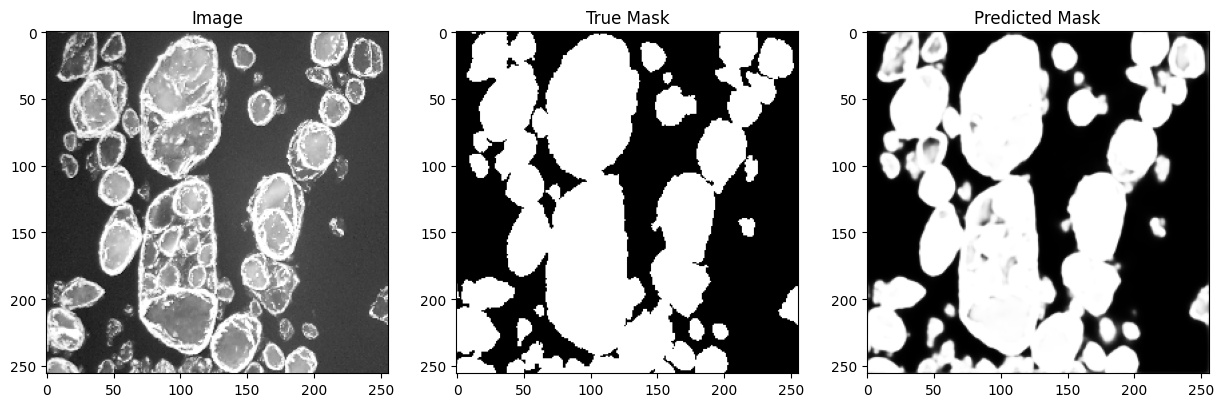

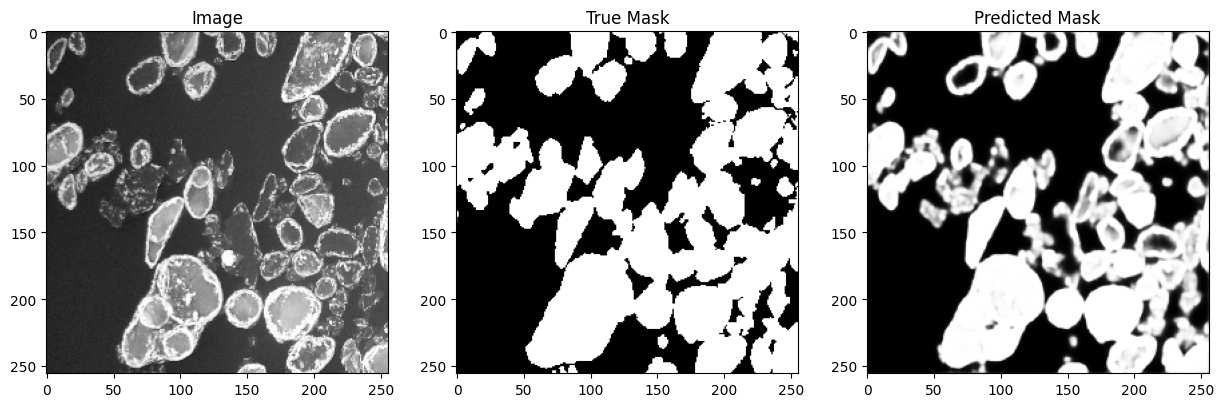

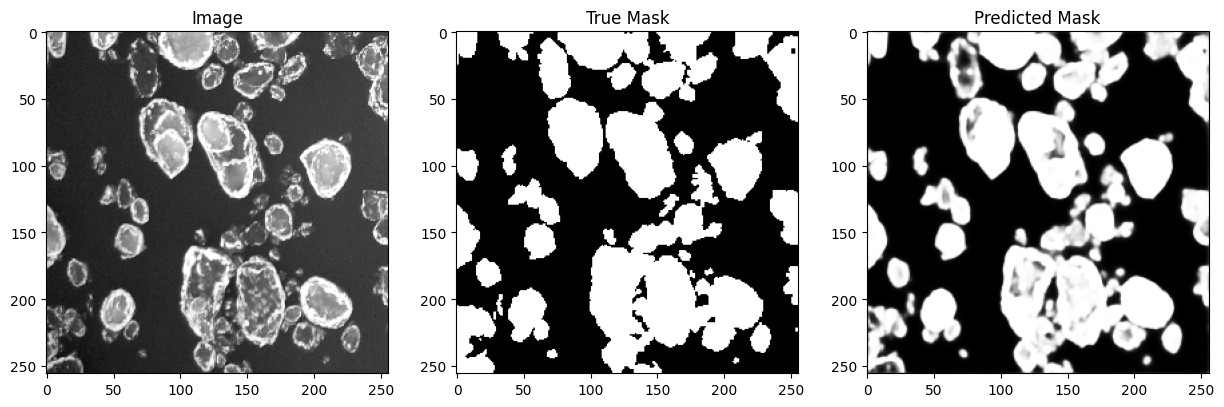

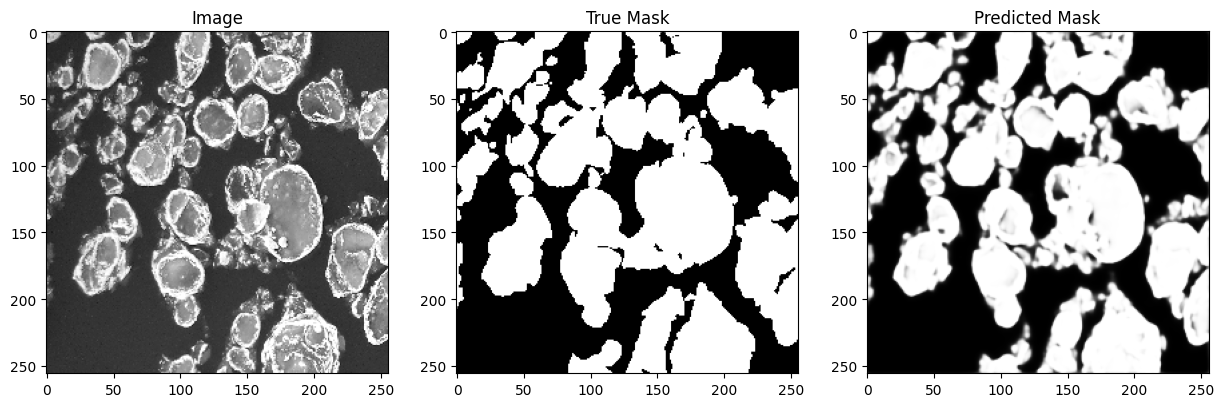

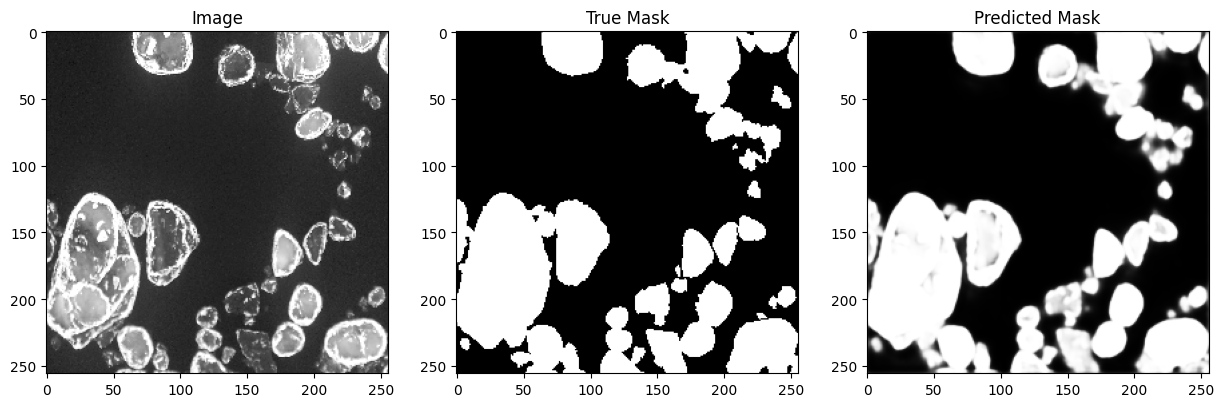

In [3]:
# Predict segmentation masks for validation images
predicted_masks = model.predict(X_val)

# Plotting some results
import matplotlib.pyplot as plt

def plot_results(img, true_mask, pred_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.show()

# Visualize some results
for i in range(5):  # Plot first 5 results
    plot_results(X_val[i], y_val[i], predicted_masks[i])

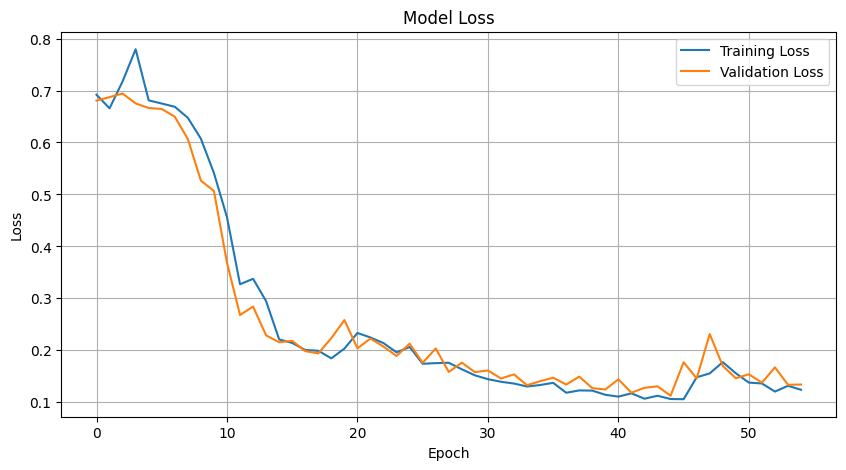

In [4]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()